In [131]:
import os.path as op
import anaconfig

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

from utils.commonutils.config import cdirs
from utils.commonutils.cdetector import get_coordinate_names
from Preprocessing.preprocessing import load_dataframes
from Preprocessing.particle_fitting_metrics import compute_particle_line_metrics_dataframe
from utils.plotutils.plotconfig import configure_matplotlib
from utils.plotutils.plotools import save_fig


configure_matplotlib()

In [42]:
outdir = op.join(anaconfig.PLOTDIR, "scifi_preprocessing")

In [116]:
def plot_xz_graph(
    df_hits_particles: pd.DataFrame,
    n_tracks: int,
    n_events: int = 10,
    seed: int | None = None,
    remove_tilted: bool = True,
    polyfit: bool = False,
):
    fig, ax = plt.subplots(figsize=(8, 6))

    event_ids = df_hits_particles["event_id"].unique()

    rng = np.random.default_rng(seed=seed)
    rng.shuffle(event_ids)

    if remove_tilted:
        df_hits_particles = df_hits_particles[df_hits_particles["dxdy"] == 0.0]


    for idx, (_, hits_particle) in enumerate(
        df_hits_particles[
            df_hits_particles["event_id"].isin(event_ids[:n_events])
            & df_hits_particles["particle_id"]
            != 0
        ].groupby(by=["event_id", "particle_id"])
    ):
        if idx >= n_tracks:
            break
        hit_coordinates = hits_particle.sort_values(by="plane")

        lines = ax.plot(
            hit_coordinates["zatyeq0"],
            hit_coordinates["xatyeq0"],
            linestyle="" if polyfit else "-",
            markersize=5.0,
            marker="o",
        )
        if polyfit:
            not_tilted_hit_coordinates = hit_coordinates[hit_coordinates["dxdy"] == 0.0]
            polynomial = Polynomial.fit(
                x=not_tilted_hit_coordinates["zatyeq0"],
                y=not_tilted_hit_coordinates["xatyeq0"],
                deg=2,
            )
            ax.plot(
                *polynomial.linspace(
                    n=100,
                    domain=[
                        hit_coordinates["zatyeq0"].min(),
                        hit_coordinates["zatyeq0"].max(),
                    ],
                ),
                linestyle="--",
                color=lines[0].get_color(),
            )

    ax.set_xlabel("z [mm]")
    ax.set_ylabel("x [mm]")
    ax.set_xlim(
        (
            df_hits_particles["zatyeq0"].min() - 100,
            df_hits_particles["zatyeq0"].max() + 100,
        )
    )
    ax.set_ylim(
        (df_hits_particles["xatyeq0"].min(), df_hits_particles["xatyeq0"].max())  # type: ignore
    )
    return fig

## Load events

In [18]:
filenames = cdirs.get_filenames_from_detector(detector="scifi")

hits_particles, particles = load_dataframes(
    indir="/scratch/acorreia/minbias-sim10b-xdigi/92",
    hits_particles_filename=filenames["hits_particles_filename"],
    particles_filename=filenames["particles_filename"],    
)


Only reconstructible particles in acceptance

In [117]:
particles_true = particles[particles["has_scifi"] & (particles["eta"] > 2) & (particles["eta"] < 5)]
hits_particles_true = hits_particles.merge(
    particles_true[["event_id", "particle_id"]],
    how="inner",
    on=["event_id", "particle_id"],
)

## Random tracks

Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/event_tracks.pdf
Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/event_tracks.png


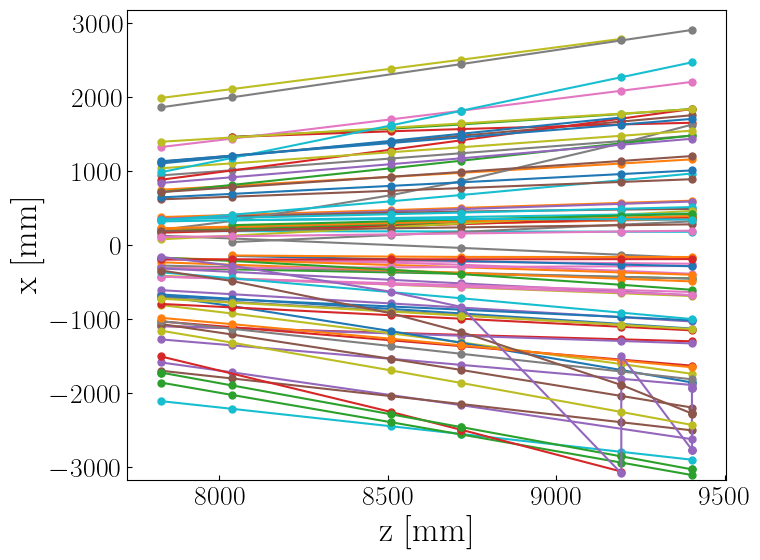

In [118]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true,
    n_tracks=100000,
    n_events=1,
    seed=1,
);
save_fig(fig, op.join(outdir, "event_tracks.pdf"))

Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/10tracks_with_tilted.pdf
Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/10tracks_with_tilted.png


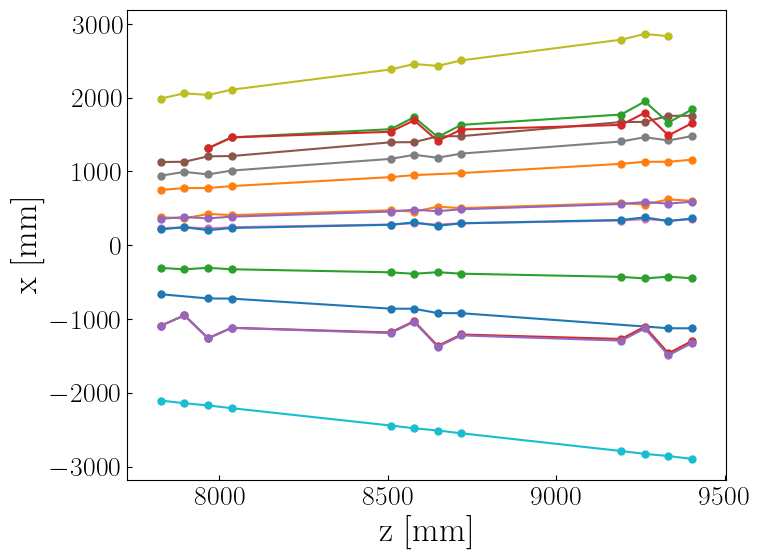

In [119]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true,
    n_tracks=15,
    n_events=1,
    remove_tilted=False,
    seed=1,
);
save_fig(fig, op.join(outdir, "10tracks_with_tilted"))

## Preprocessing steps

### At most 2 hits / plane

In [120]:
def get_particles_having_more_than_n_hits_per_plane(
    df_hits_particles: pd.DataFrame,
    n_hits: int,
) -> pd.DataFrame:
    particles_having_more_than_n_hits_per_plane = (
        (
            df_hits_particles.groupby(["event_id", "particle_id", "plane"])[
                "hit_id"
            ].count()
            > n_hits
        )
        .groupby(["event_id", "particle_id"])
        .max()
    )
    return particles_having_more_than_n_hits_per_plane[particles_having_more_than_n_hits_per_plane].reset_index()[["event_id", "particle_id"]]

In [121]:
print(
    "Proportion",
    f"{get_particles_having_more_than_n_hits_per_plane(hits_particles_true, 2).shape[0]/ particles_true.shape[0]:.2%}",
)

Proportion 1.26%


Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_more_than_2_hits_on_plane.pdf
Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_more_than_2_hits_on_plane.png


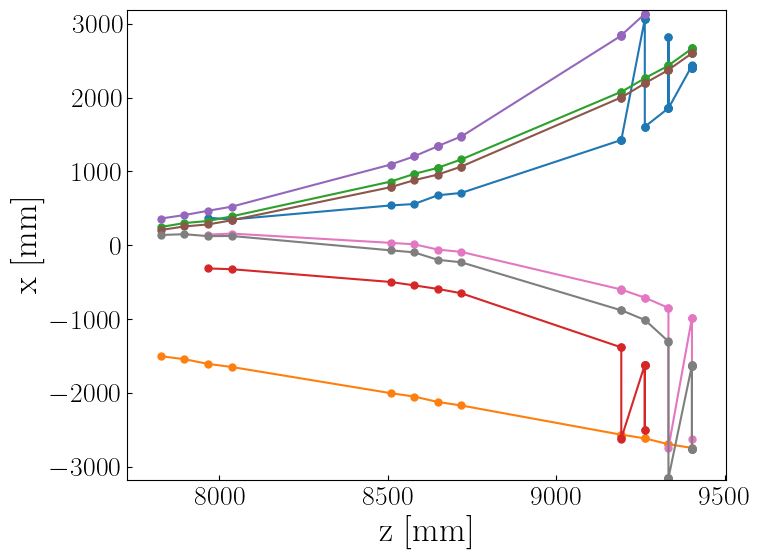

In [122]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true.merge(
        get_particles_having_more_than_n_hits_per_plane(hits_particles_true, 2),
        how="inner",
        on=["event_id", "particle_id"],
    ),
    n_tracks=8,
    n_events=100,
    remove_tilted=False,
    seed=1,
);
save_fig(fig, op.join(outdir, "tracks_more_than_2_hits_on_plane"))

## Not Polynomial enough

In [125]:
poly_metrics = compute_particle_line_metrics_dataframe(
    hits_particles_true[hits_particles_true["dxdy"] == 0.0],
    metric_names=["distance_to_poly"],
    coord_names=get_coordinate_names("scifi"),
    line_type="quadpoly_2d",
)
particles_true = particles_true.merge(
    poly_metrics.reset_index(),
    how="left",
    on=["event_id", "particle_id"],
)

In [126]:
print(
    "Proportion",
    f"{(particles_true['distance_to_poly'] >= 70.0).sum()/ particles_true.shape[0]:.2%}",
)

Proportion 0.13%


Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_more_than_2_hits_on_plane.pdf
Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_more_than_2_hits_on_plane.png


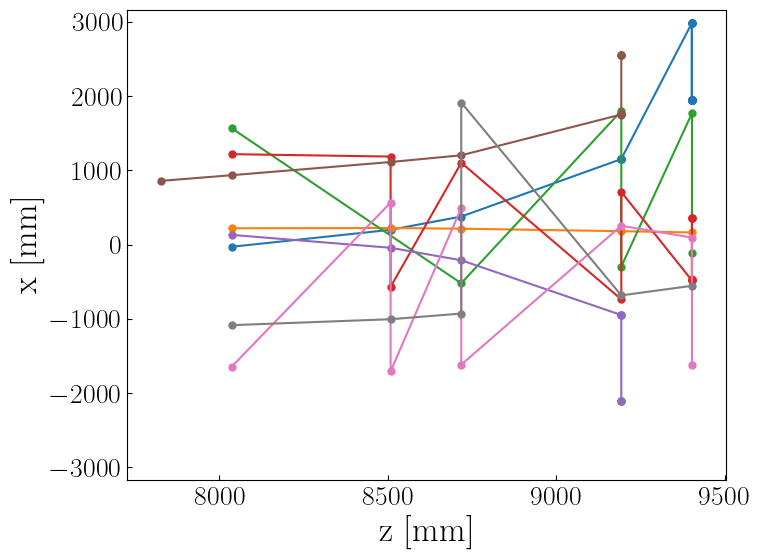

In [140]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true.merge(
        particles_true[particles_true['distance_to_poly'] >= 70.0],
        how="inner",
        on=["event_id", "particle_id"],
    ),
    n_tracks=8,
    n_events=100,
    seed=1,
);
save_fig(fig, op.join(outdir, "tracks_more_than_2_hits_on_plane"))

Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_poly_enough.pdf
Figure was saved in /home/acorreia/etx4velo/etx4velo/output/preliminary/scifi_preprocessing/tracks_poly_enough.png


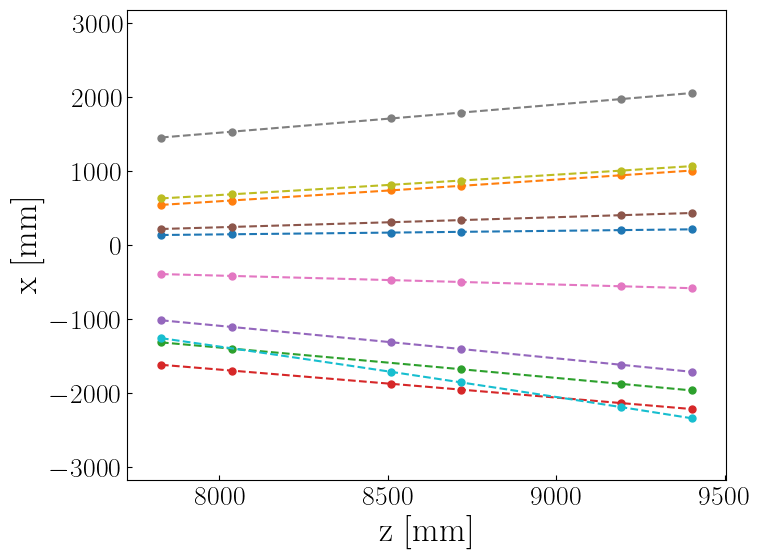

In [134]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true.merge(
        particles_true[particles_true['distance_to_poly'] < 70.0],
        how="inner",
        on=["event_id", "particle_id"],
    ),
    n_tracks=10,
    n_events=100,
    seed=1,
    polyfit=True,
);

save_fig(fig, op.join(outdir, "tracks_poly_enough"))

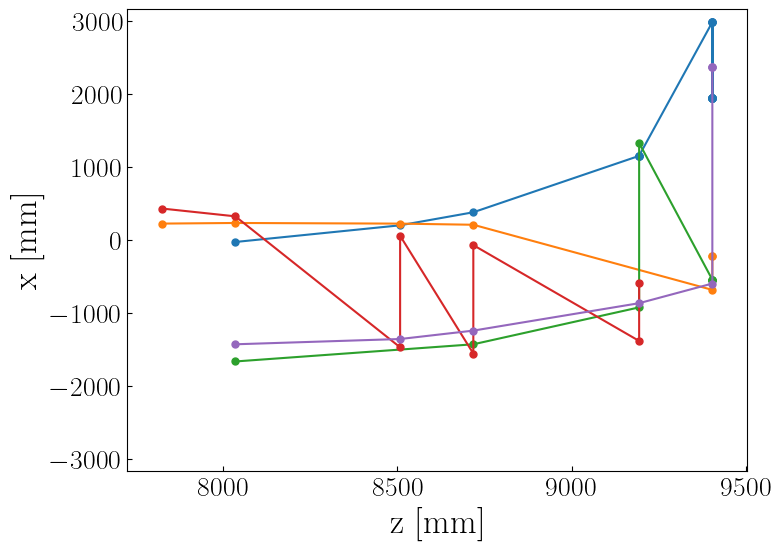

In [148]:
fig = plot_xz_graph(
    df_hits_particles=hits_particles_true.merge(
        particles_true[particles_true['distance_to_poly'] >= 70.0],
        how="inner",
        on=["event_id", "particle_id"],
    ),
    n_tracks=5,
    n_events=100,
);